In [1]:
import os
import torch
import numpy as np

os.environ["WANDB_ENABLED"] = "false"

from engine.solver import Trainer
from data.build_dataloader import build_dataloader
# from utils.metric_utils import visualization
from utils.io_utils import load_yaml_config, instantiate_from_config
from models.model_utils import unnormalize_to_zero_to_one

In [2]:
# import torch
# import matplotlib.pyplot as plt

# model = torch.nn.Linear(2, 1)
# optimizer = torch.optim.SGD(model.parameters(), lr=1)
# lr_sched = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=7, T_mult=1, eta_min=0.01, last_epoch=-1)


# lrs = []

# for i in range(60):
#     lr_sched.step()
#     lrs.append(
#         optimizer.param_groups[0]["lr"]
#     )

# plt.plot(lrs)

### Build dataset and settings

In [3]:
# !cat ./config/control/revenue-regression.yaml

In [4]:
class Arguments:
    def __init__(self) -> None:
        self.config_path = "./config/control/revenue-baseline-365.yaml"
        # self.config_path = "./config/control/revenue-baseline-sine.yaml"
        self.save_dir = (
            "../../../data/" + os.path.basename(self.config_path).split(".")[0]
        )
        self.gpu = 0
        os.makedirs(self.save_dir, exist_ok=True)

        self.mode = "infill"
        self.missing_ratio = 0.95
        self.milestone = 10

args = Arguments()
configs = load_yaml_config(args.config_path)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(args.gpu)

dl_info = build_dataloader(configs, args)
model = instantiate_from_config(configs["model"]).to(device)
trainer = Trainer(config=configs, args=args, model=model, dataloader=dl_info)
# trainer.load(args.milestone, from_folder="../../../data/ckpt_baseline_240")


/home/mila/h/hao.yu/tencent/Tifussion/tiffusion/external/diffusion-ts/utils/data_utils/real_datasets.py:282: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath)


Dataset load from ../../../data/daily.csv with shape (222, 365, 3)


### Training models

In [5]:
# trainer.train()

## Inference and Visualizations

In [6]:
from data.build_dataloader import build_dataloader_cond
# args.milestone
trainer.load("10")
test_dl_info = build_dataloader_cond(configs, args)
test_dataloader, test_dataset = test_dl_info["dataloader"], test_dl_info["dataset"]
coef = configs["dataloader"]["test_dataset"]["coefficient"]
stepsize = configs["dataloader"]["test_dataset"]["step_size"]
sampling_steps = configs["dataloader"]["test_dataset"]["sampling_steps"]
seq_length, feature_dim = test_dataset.window, test_dataset.var_num
samples, ori_data, masks = trainer.restore(
    test_dataloader,
    [seq_length, feature_dim],
    coef,
    stepsize,
    sampling_steps,
    control_signal={},
)
import matplotlib.pyplot as plt
import pandas as pd
if test_dataset.auto_norm:
    samples = unnormalize_to_zero_to_one(samples)

# ori_data = np.load(os.path.join(dataset.dir, f"sine_ground_truth_{seq_length}_test.npy"))
dataset_name = "revenue"
ori_data = np.load(
    os.path.join(test_dataset.dir, f"{dataset_name}_norm_truth_{seq_length}_test.npy")
)  # Uncomment the line if dataset other than Sine is used.
masks = np.load(os.path.join(test_dataset.dir, f"{dataset_name}_masking_{seq_length}.npy"))
# masks = np.load(os.path.join(dataset.dir, f"sine_masking_{seq_length}.npy"))
sample_num, seq_len, feat_dim = ori_data.shape
observed = ori_data * masks

/home/mila/h/hao.yu/tencent/Tifussion/tiffusion/external/diffusion-ts/utils/data_utils/real_datasets.py:282: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath)


Dataset load from ../../../data/daily.csv with shape (55, 365, 3)
fast sampling


conditional sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

Losses - Diffusion: 0.0000	Infill: 0.0511	
Losses - Diffusion: 0.0000	Infill: 0.0380	
Losses - Diffusion: 0.0000	Infill: 0.0301	
Losses - Diffusion: 0.0000	Infill: 0.0256	
Losses - Diffusion: 0.0000	Infill: 0.0225	
Losses - Diffusion: 0.0000	Infill: 0.0216	
Losses - Diffusion: 0.0000	Infill: 0.0198	
Losses - Diffusion: 0.0000	Infill: 0.0187	
Losses - Diffusion: 0.0000	Infill: 0.0174	
Losses - Diffusion: 0.0000	Infill: 0.0168	
Losses - Diffusion: 0.0000	Infill: 0.0162	
Losses - Diffusion: 0.0000	Infill: 0.0164	
Losses - Diffusion: 0.0000	Infill: 0.0171	
Losses - Diffusion: 0.0000	Infill: 0.0178	
Losses - Diffusion: 0.0000	Infill: 0.0177	
Losses - Diffusion: 0.0000	Infill: 0.0176	
Losses - Diffusion: 0.0000	Infill: 0.0186	
Losses - Diffusion: 0.0000	Infill: 0.0187	
Losses - Diffusion: 0.0000	Infill: 0.0187	
Losses - Diffusion: 0.0000	Infill: 0.0183	
Losses - Diffusion: 0.0000	Infill: 0.0192	
Losses - Diffusion: 0.0000	Infill: 0.0194	
Losses - Diffusion: 0.0000	Infill: 0.0191	
Losses - Di

In [7]:
# assert False

Feature 0 RMSE: 0.10035132894085291
Feature 0 MAE: 0.07856495265240844
Sum of target values: 113.33637330761863
Sum of predicted values: 117.3444813489914
Feature 1 RMSE: 0.12339873435318657
Feature 1 MAE: 0.08426083770054163
Sum of target values: 46.55387231656055
Sum of predicted values: 46.69564789533615
Feature 2 RMSE: 0.042881391427933006
Feature 2 MAE: 0.033029933607378145
Sum of target values: 42.144023249989424
Sum of predicted values: 38.016870483756065


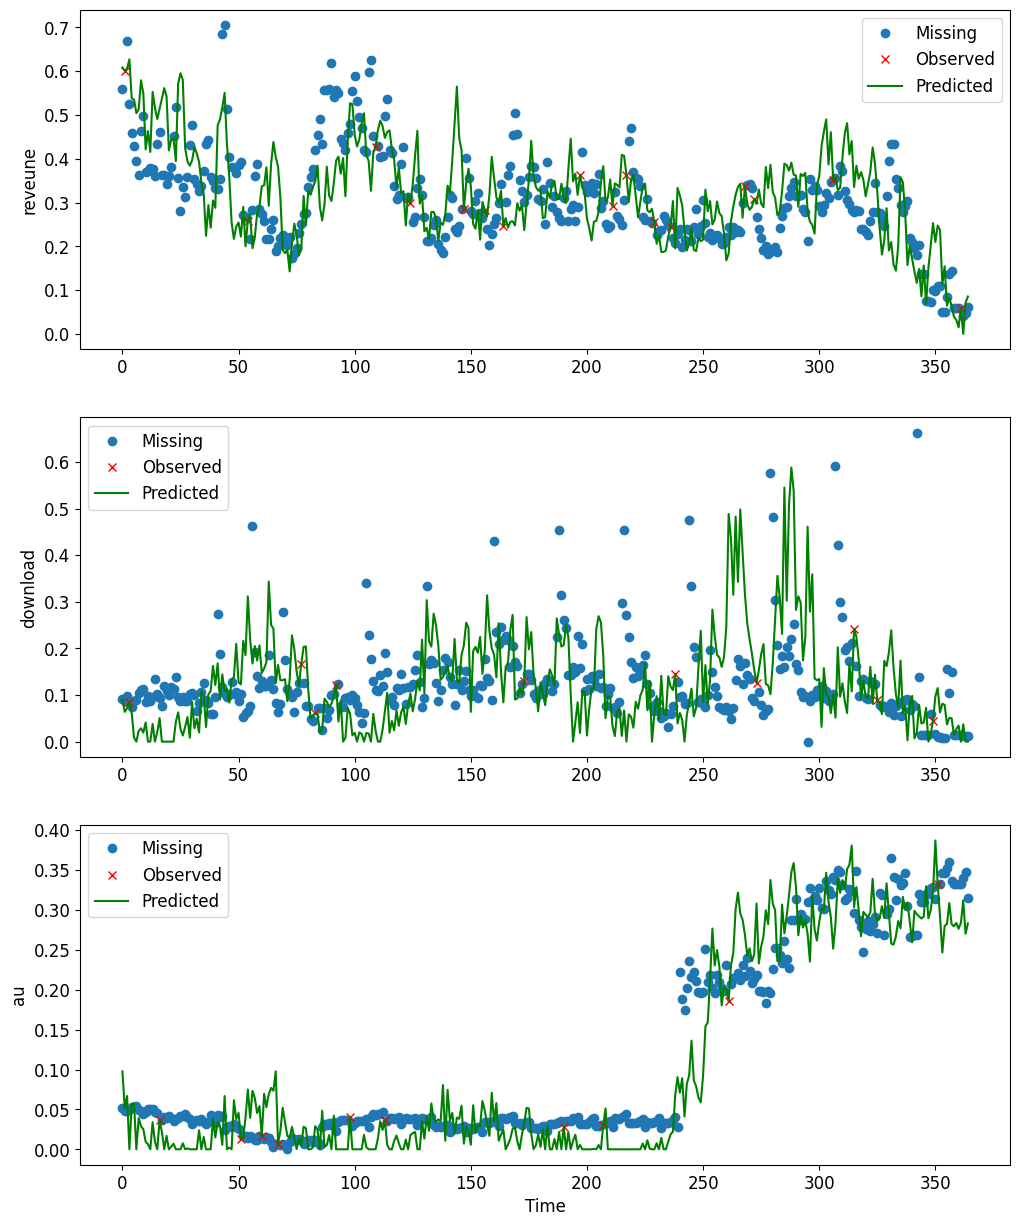

In [8]:

# def diplay(sample_index = 4):
sample_index = 0
plt.rcParams["font.size"] = 12
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 15))

for feat_idx in range(feat_dim):
    df_x = pd.DataFrame({
        "x": np.arange(0, seq_len),
        "val": ori_data[sample_index, :, feat_idx],
        "y": masks[sample_index, :, feat_idx],
    })
    df_x = df_x[df_x.y != 0]

    df_o = pd.DataFrame({
        "x": np.arange(0, seq_len),
        "val": ori_data[sample_index, :, feat_idx],
        "y": (1 - masks)[sample_index, :, feat_idx],
    })
    df_o = df_o[df_o.y != 0]

    axes[feat_idx].plot(df_o.x, df_o.val, linestyle="None", marker="o", label="Missing") # , color="b"
    axes[feat_idx].plot(df_x.x, df_x.val, color="r", marker="x", linestyle="None", label="Observed")
    axes[feat_idx].plot(
        range(0, seq_len),
        samples[sample_index, :, feat_idx],
        color="g",
        linestyle="solid",
        label="Predicted",
    )

    axes[feat_idx].set_ylabel(["reveune", "download", "au"][feat_idx])
    if feat_idx == feat_dim - 1:
        axes[feat_idx].set_xlabel("Time")

    axes[feat_idx].legend()

    print(f"Feature {feat_idx} RMSE: {np.sqrt(np.mean((samples[0, :, feat_idx] - ori_data[0, :, feat_idx])**2))}")
    print(f"Feature {feat_idx} MAE: {np.mean(np.abs(samples[0, :, feat_idx] - ori_data[0, :, feat_idx]))}")
    # sum of all target values and predicted values
    print(f"Sum of target values: {np.sum(ori_data[0, :, feat_idx])}")
    print(f"Sum of predicted values: {np.sum(samples[0, :, feat_idx])}")

fig.show()

# diplay(5)

### Sampling

In [18]:
import pickle
from pathlib import Path

# Cache file path
cache_dir = Path("cache")
cache_dir.mkdir(exist_ok=True)

def load_cached_results():
    results = {'unconditional': None, 'sum_controlled': {}, 'anchor_controlled': {}}
    for cache_file in cache_dir.glob('*.pkl'):
        with open(cache_file, 'rb') as f:
            key = cache_file.stem
            if key == 'unconditional':
                results['unconditional'] = pickle.load(f)
            elif key.startswith('sum_'):
                param = key[4:]  # Remove 'sum_' prefix
                results['sum_controlled'][param] = pickle.load(f)
            elif key.startswith('anchor_'):
                param = key[7:]  # Remove 'anchor_' prefix
                results['anchor_controlled'][param] = pickle.load(f)
    return results

def save_result(key, subkey, data):
    if subkey:
        filename = f"{key}_{subkey}.pkl"
    else:
        filename = f"{key}.pkl"
    with open(cache_dir / filename, 'wb') as f:
        pickle.dump(data, f)

results = load_cached_results()

dataset = dl_info["dataset"]
seq_length, feature_dim = dataset.window, dataset.var_num
coef = configs["dataloader"]["test_dataset"]["coefficient"]
stepsize = configs["dataloader"]["test_dataset"]["step_size"]

ori_data = np.load(
    os.path.join(dataset.dir, f"{dataset_name}_norm_truth_{seq_length}_train.npy")
)

# Unconditional sampling
if results['unconditional'] is None:
    print("Generating unconditional data...")
    results['unconditional'] = trainer.sample(
        num=len(dataset), size_every=100, shape=[seq_length, feature_dim]
    )
    save_result('unconditional', None, results['unconditional'])

# Different AUC weights
auc_weights = [1.0, 5.0, 10.0, 15.0]
auc_values = [-200, -150, -100, 50, 100, 150]

for auc in auc_values:
    for weight in auc_weights:
        key = f"auc_{auc}_weight_{weight}"
        if key not in results['sum_controlled']:
            print(f"Generating sum controlled data - AUC: {auc}, Weight: {weight}")
            results['sum_controlled'][key] = trainer.control_sample(
                num=len(dataset), size_every=100, shape=[seq_length, feature_dim],
                model_kwargs={
                    "gradient_control_signal": {"auc": auc, "auc_weight": weight},
                    "coef": coef,
                    "learning_rate": stepsize
                }
            )
            save_result('sum', key, results['sum_controlled'][key])

# Different weekly peaks
peak_values = [0.6, 0.8, 1.0]
peak_weights = [0.05, 0.1, 0.15]

for peak in peak_values:
    for weight in peak_weights:
        key = f"peak_{peak}_weight_{weight}"
        if key not in results['anchor_controlled']:
            mask = np.zeros((seq_length, feature_dim), dtype=np.float32)
            mask[::7, 0] = weight
            target = np.zeros((seq_length, feature_dim), dtype=np.float32)
            target[::7, 0] = peak
            
            print(f"Generating anchor controlled data - Peak: {peak}, Weight: {weight}")
            results['anchor_controlled'][key] = trainer.control_sample(
                num=len(dataset), size_every=100, shape=[seq_length, feature_dim],
                model_kwargs={
                    "gradient_control_signal": {"auc": 0, "auc_weight": 10.0},
                    "coef": coef,
                    "learning_rate": stepsize
                },
                target=target,
                partial_mask=mask
            )
            save_result('anchor', key, results['anchor_controlled'][key])

# Unnormalize results if needed
if dataset.auto_norm:
    for key, data in results.items():
        if isinstance(data, dict):
            for subkey, subdata in data.items():
                results[key][subkey] = unnormalize_to_zero_to_one(subdata)
        else:
            results[key] = unnormalize_to_zero_to_one(data)

# Store the results in variables for compatibility with existing code
unconditional_data = results['unconditional']
sum_controled_data = results['sum_controlled']# ['auc_0_weight_10.0']  # default values
anchor_controled_data = results['anchor_controlled']#['peak_0.8_weight_0.1']  # default values

model_kwargs {'coef': 0.01, 'learning_rate': 0.05}
partial_mask torch.Size([10, 365, 3])
target torch.Size([10, 365, 3])


conditional sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

Losses - Diffusion: 0.0000	Infill: 0.5880	
Losses - Diffusion: 0.0000	Infill: 0.5099	
Losses - Diffusion: 0.0000	Infill: 0.4487	
Losses - Diffusion: 0.0000	Infill: 0.4074	
Losses - Diffusion: 0.0000	Infill: 0.3794	
Losses - Diffusion: 0.0000	Infill: 0.3583	
Losses - Diffusion: 0.0000	Infill: 0.3369	
Losses - Diffusion: 0.0000	Infill: 0.3148	
Losses - Diffusion: 0.0000	Infill: 0.2924	
Losses - Diffusion: 0.0000	Infill: 0.2694	
Losses - Diffusion: 0.0000	Infill: 0.2437	
Losses - Diffusion: 0.0000	Infill: 0.2258	
Losses - Diffusion: 0.0000	Infill: 0.2027	
Losses - Diffusion: 0.0000	Infill: 0.1802	
Losses - Diffusion: 0.0000	Infill: 0.1579	
Losses - Diffusion: 0.0000	Infill: 0.1386	
Losses - Diffusion: 0.0000	Infill: 0.1156	
Losses - Diffusion: 0.0000	Infill: 0.0972	
Losses - Diffusion: 0.0000	Infill: 0.0728	
Losses - Diffusion: 0.0000	Infill: 0.0575	
Losses - Diffusion: 0.0000	Infill: 0.0425	
Losses - Diffusion: 0.0000	Infill: 0.0389	
Losses - Diffusion: 0.0000	Infill: 0.0359	
Losses - Di

conditional sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

Losses - Diffusion: 0.0000	Infill: 0.5557	
Losses - Diffusion: 0.0000	Infill: 0.4781	
Losses - Diffusion: 0.0000	Infill: 0.4264	
Losses - Diffusion: 0.0000	Infill: 0.3910	
Losses - Diffusion: 0.0000	Infill: 0.3637	
Losses - Diffusion: 0.0000	Infill: 0.3432	
Losses - Diffusion: 0.0000	Infill: 0.3189	
Losses - Diffusion: 0.0000	Infill: 0.2981	
Losses - Diffusion: 0.0000	Infill: 0.2761	
Losses - Diffusion: 0.0000	Infill: 0.2496	
Losses - Diffusion: 0.0000	Infill: 0.2313	
Losses - Diffusion: 0.0000	Infill: 0.2063	
Losses - Diffusion: 0.0000	Infill: 0.1831	
Losses - Diffusion: 0.0000	Infill: 0.1589	
Losses - Diffusion: 0.0000	Infill: 0.1350	
Losses - Diffusion: 0.0000	Infill: 0.1140	
Losses - Diffusion: 0.0000	Infill: 0.0985	
Losses - Diffusion: 0.0000	Infill: 0.0777	
Losses - Diffusion: 0.0000	Infill: 0.0596	
Losses - Diffusion: 0.0000	Infill: 0.0411	
Losses - Diffusion: 0.0000	Infill: 0.0306	
Losses - Diffusion: 0.0000	Infill: 0.0275	
Losses - Diffusion: 0.0000	Infill: 0.0234	
Losses - Di

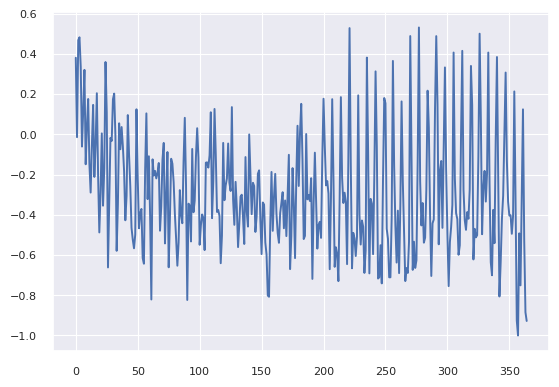

In [31]:
mask = np.zeros((seq_length, feature_dim), dtype=np.float32)
mask[200::7, 0] = 0.1
target = np.zeros((seq_length, feature_dim), dtype=np.float32)
target[200::7, 0] = 0.8

plt.plot(trainer.control_sample(
                num=10, size_every=10, shape=[seq_length, feature_dim],
                model_kwargs={
                    # "gradient_control_signal": {"auc": 0, "auc_weight": 10.0},
                    "coef": coef,
                    "learning_rate": stepsize
                },
                target=target,
                partial_mask=mask
            )[0, :, 0], label="control")


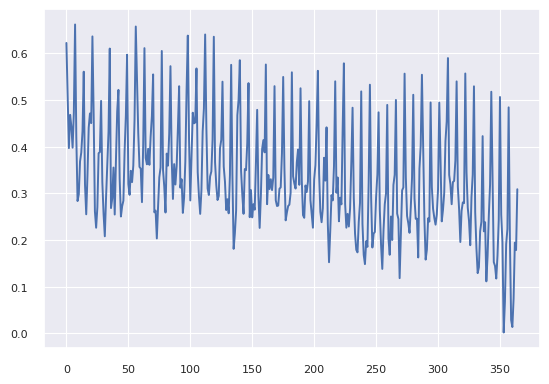

In [29]:
results['anchor_controlled']['peak_0.8_weight_0.1'][0,:,0], label="Original")


Evaluating peak_1.0_weight_0.15
Accuracy: 0.962
Precision: 37.500
Matched peaks: 15300 / 15900


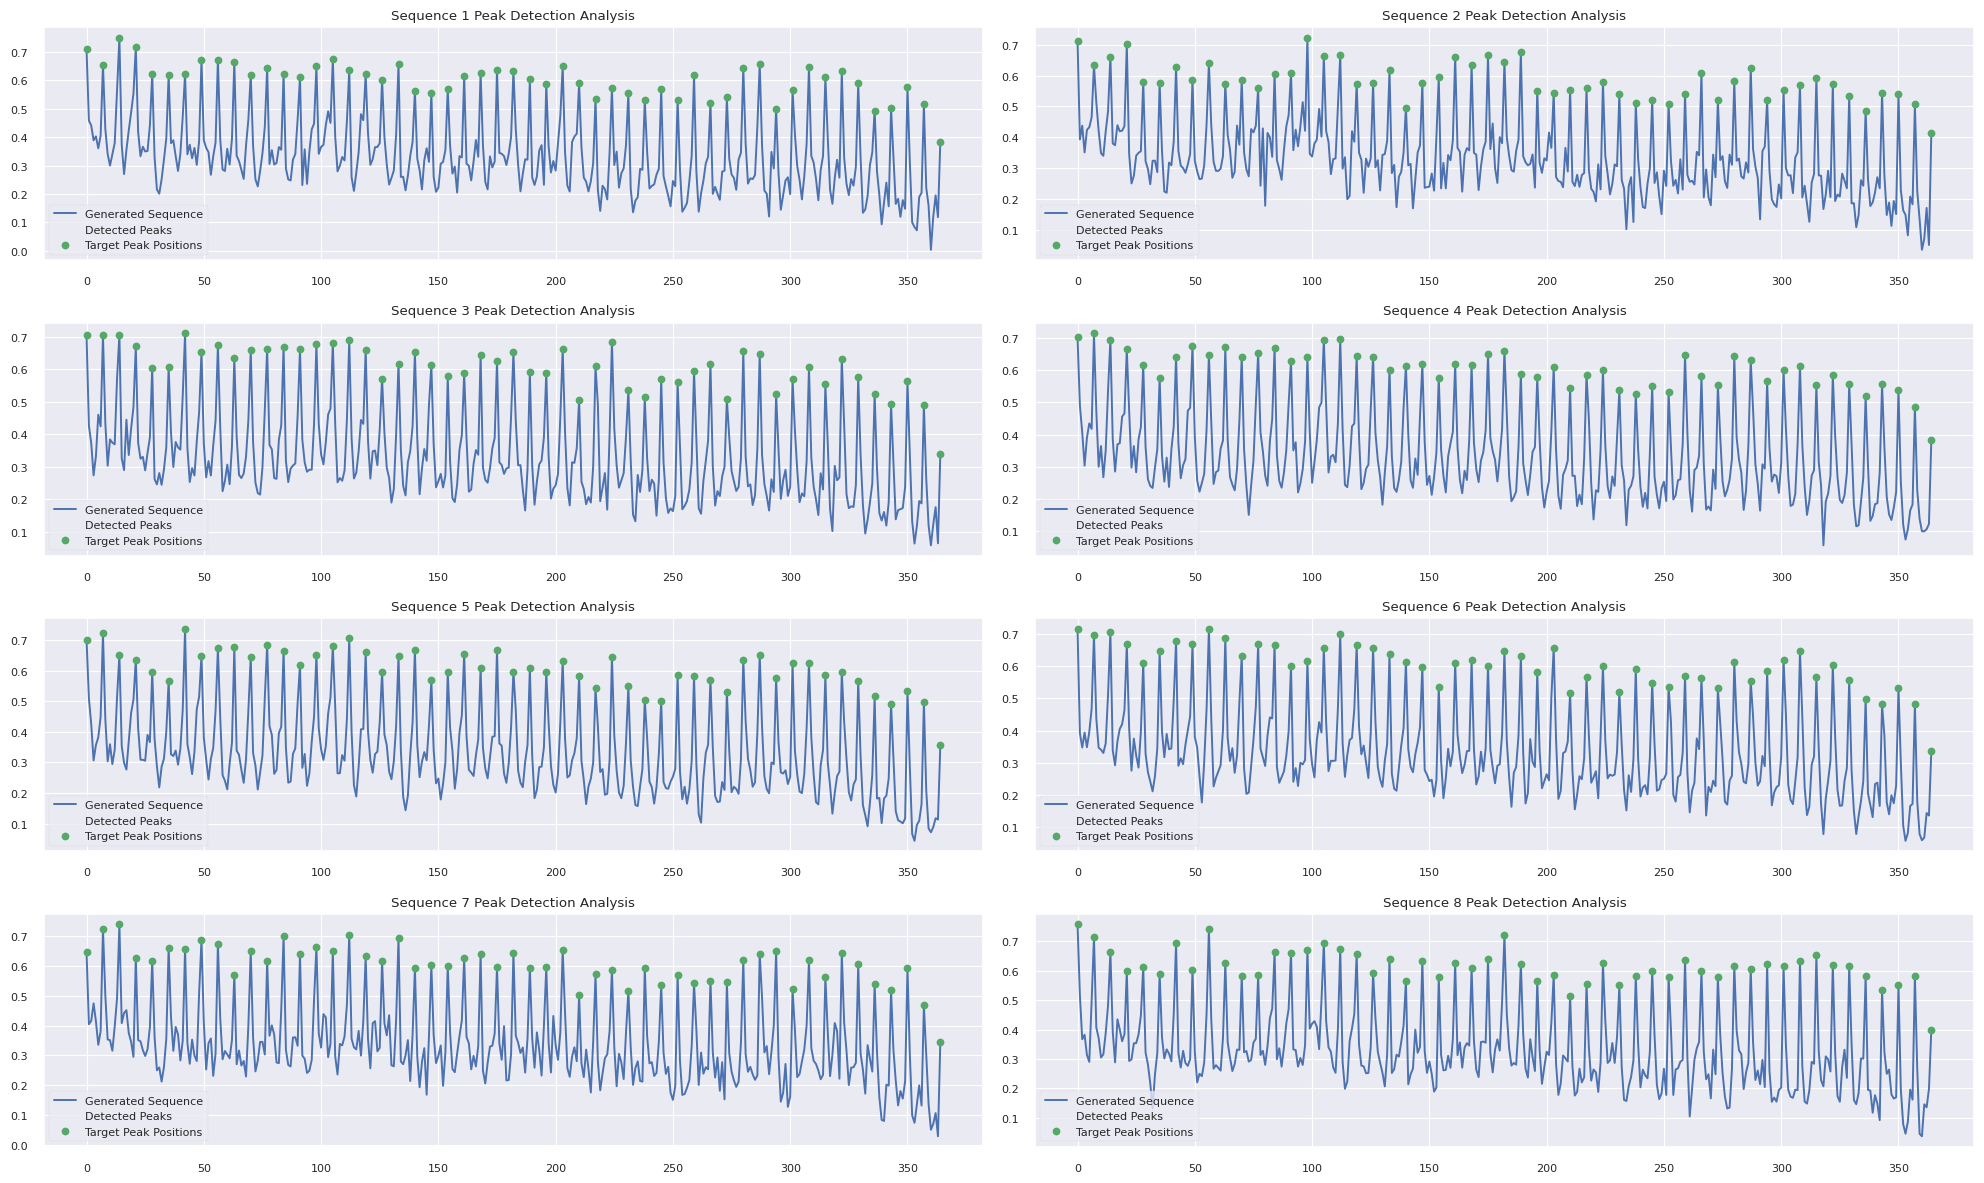


Evaluating peak_1.0_weight_0.05
Accuracy: 0.962
Precision: 37.488
Matched peaks: 15295 / 15900


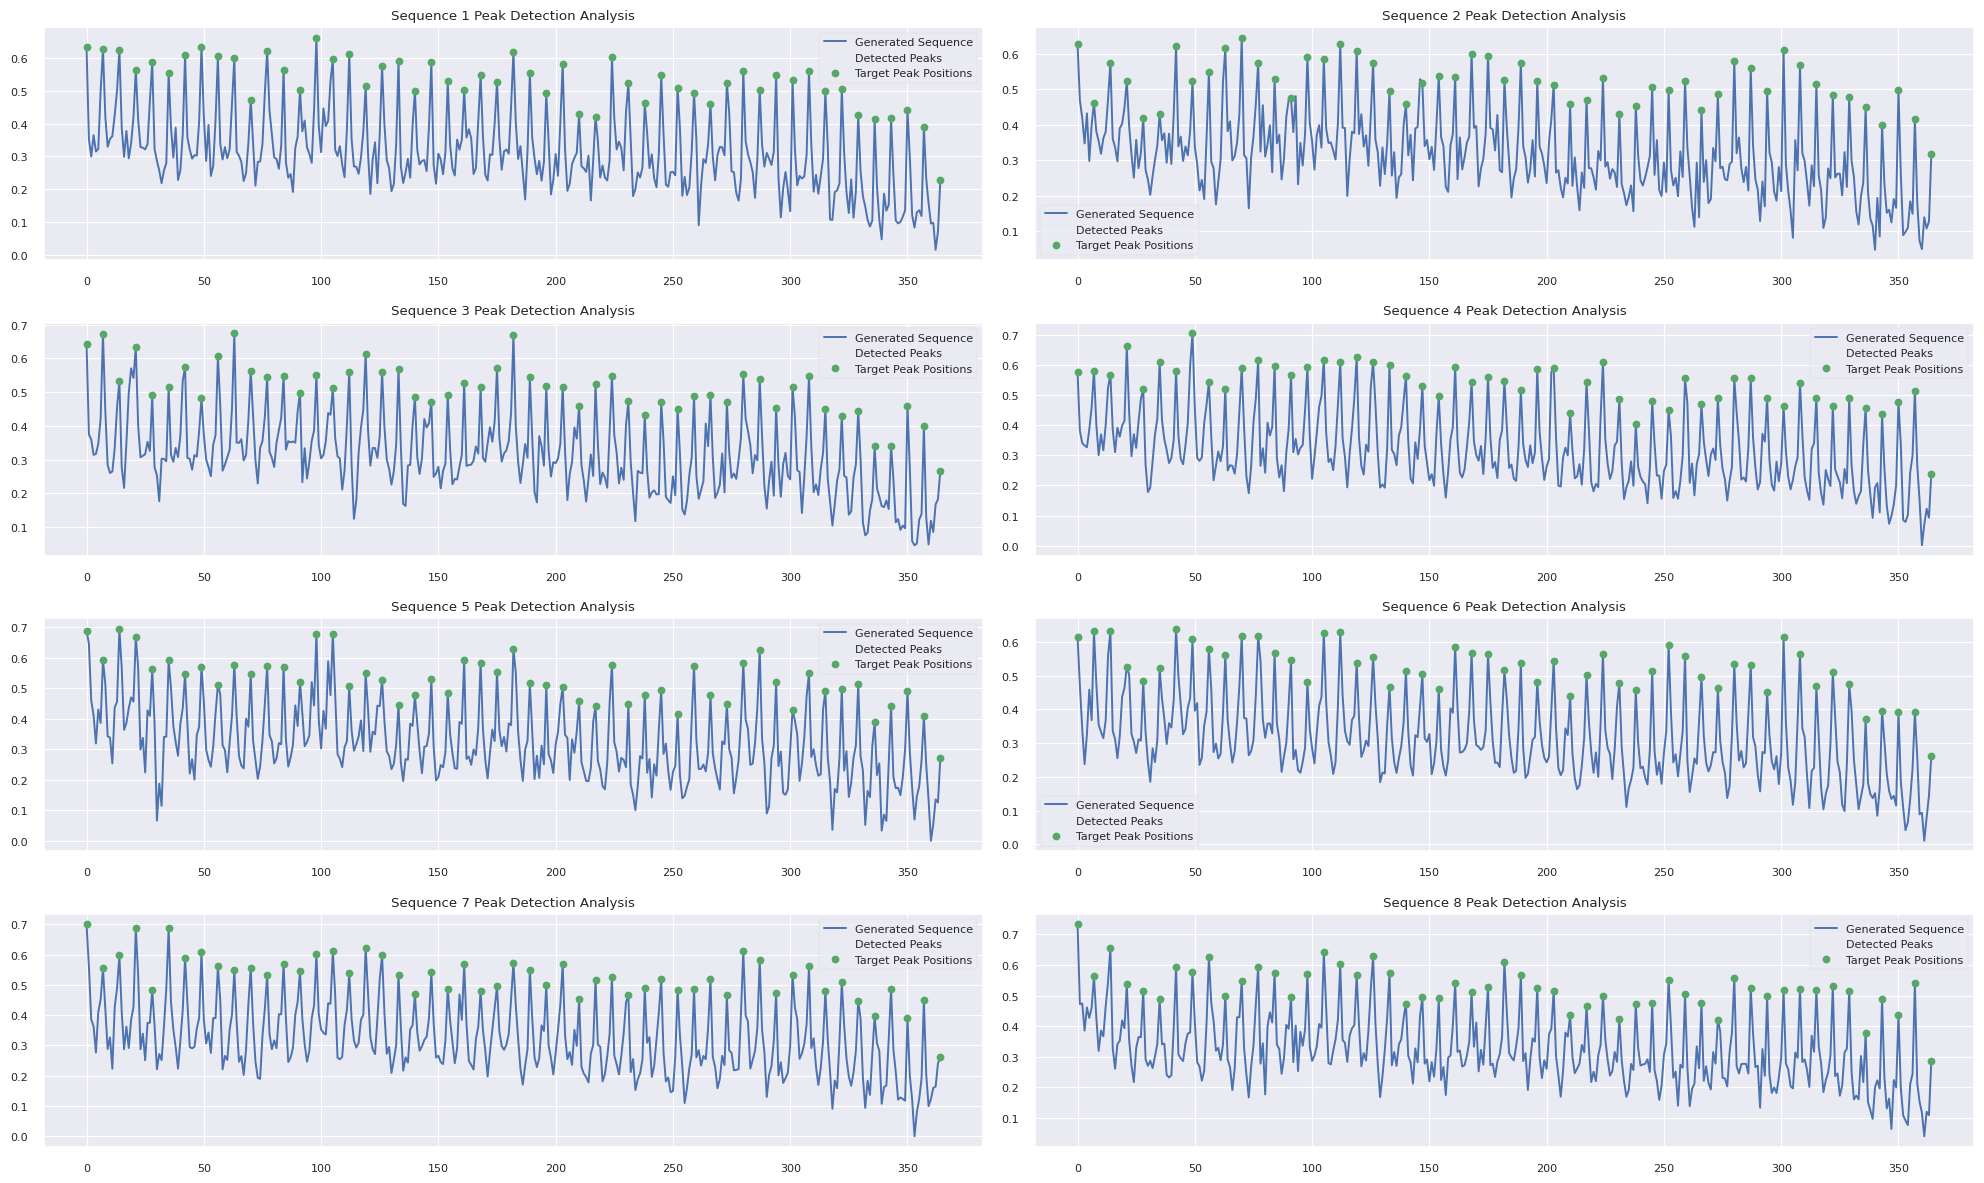


Evaluating peak_0.6_weight_0.1
Accuracy: 0.962
Precision: 37.488
Matched peaks: 15295 / 15900


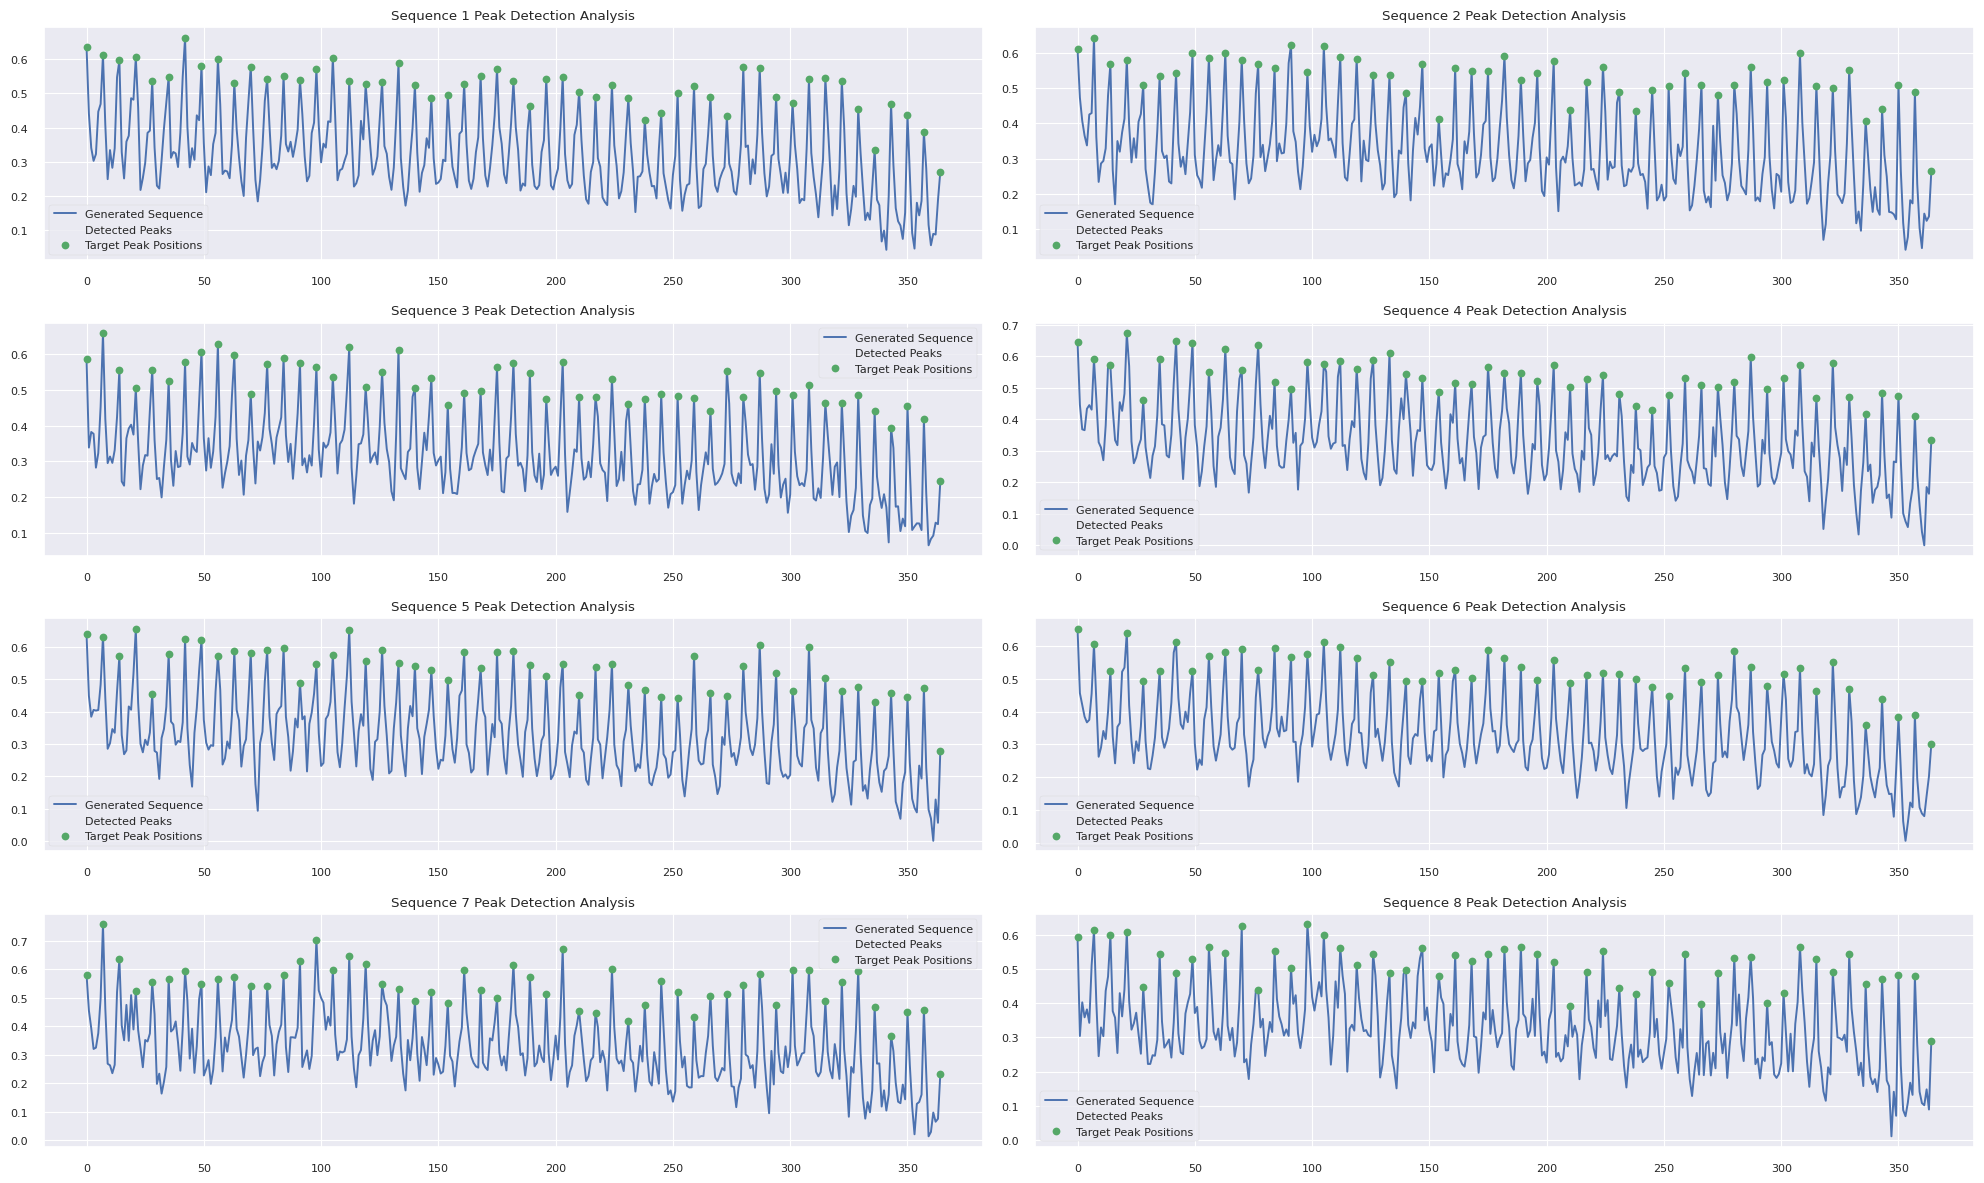


Evaluating peak_0.6_weight_0.15
Accuracy: 0.962
Precision: 37.500
Matched peaks: 15300 / 15900


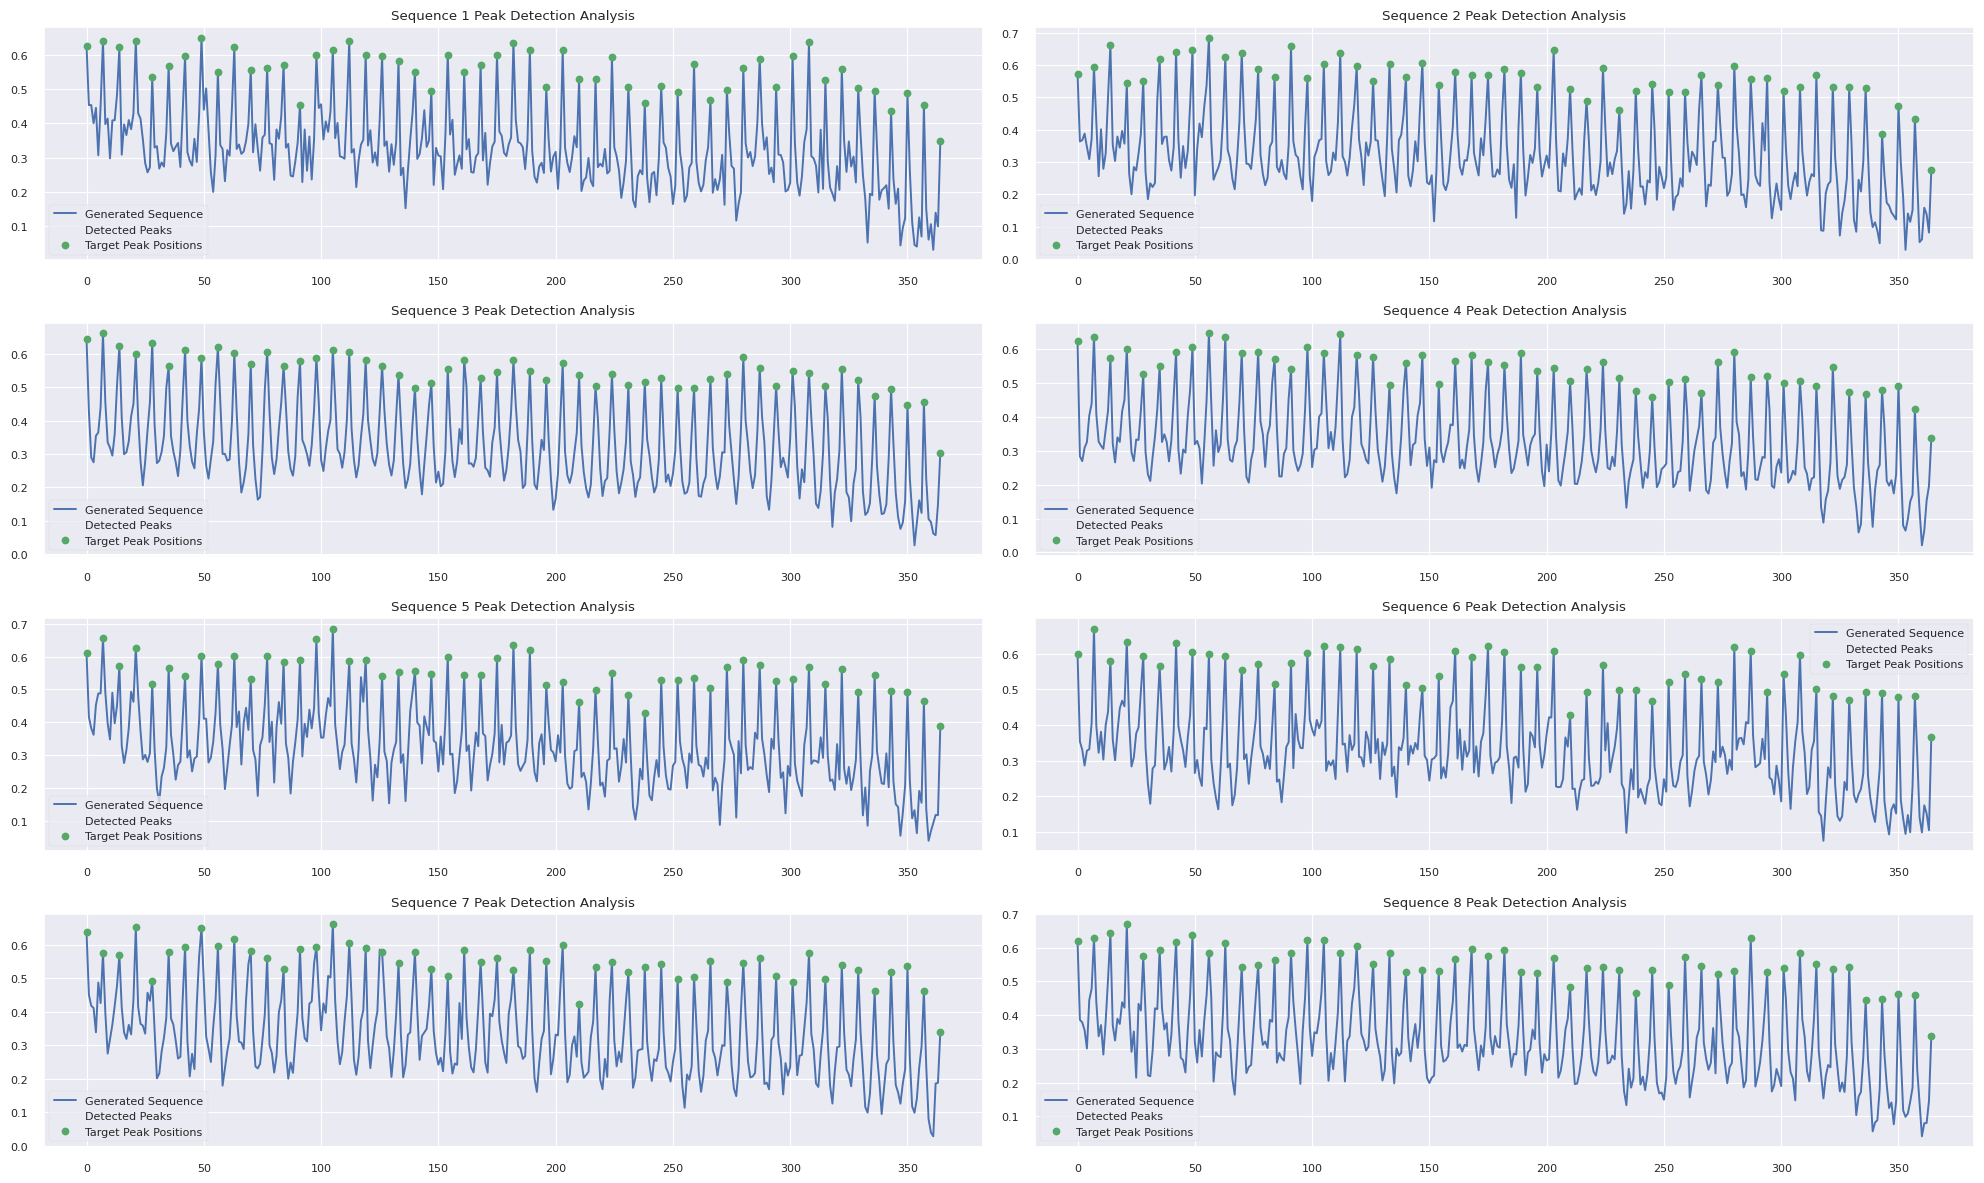


Evaluating peak_0.8_weight_0.05
Accuracy: 0.961
Precision: 37.468
Matched peaks: 15287 / 15900


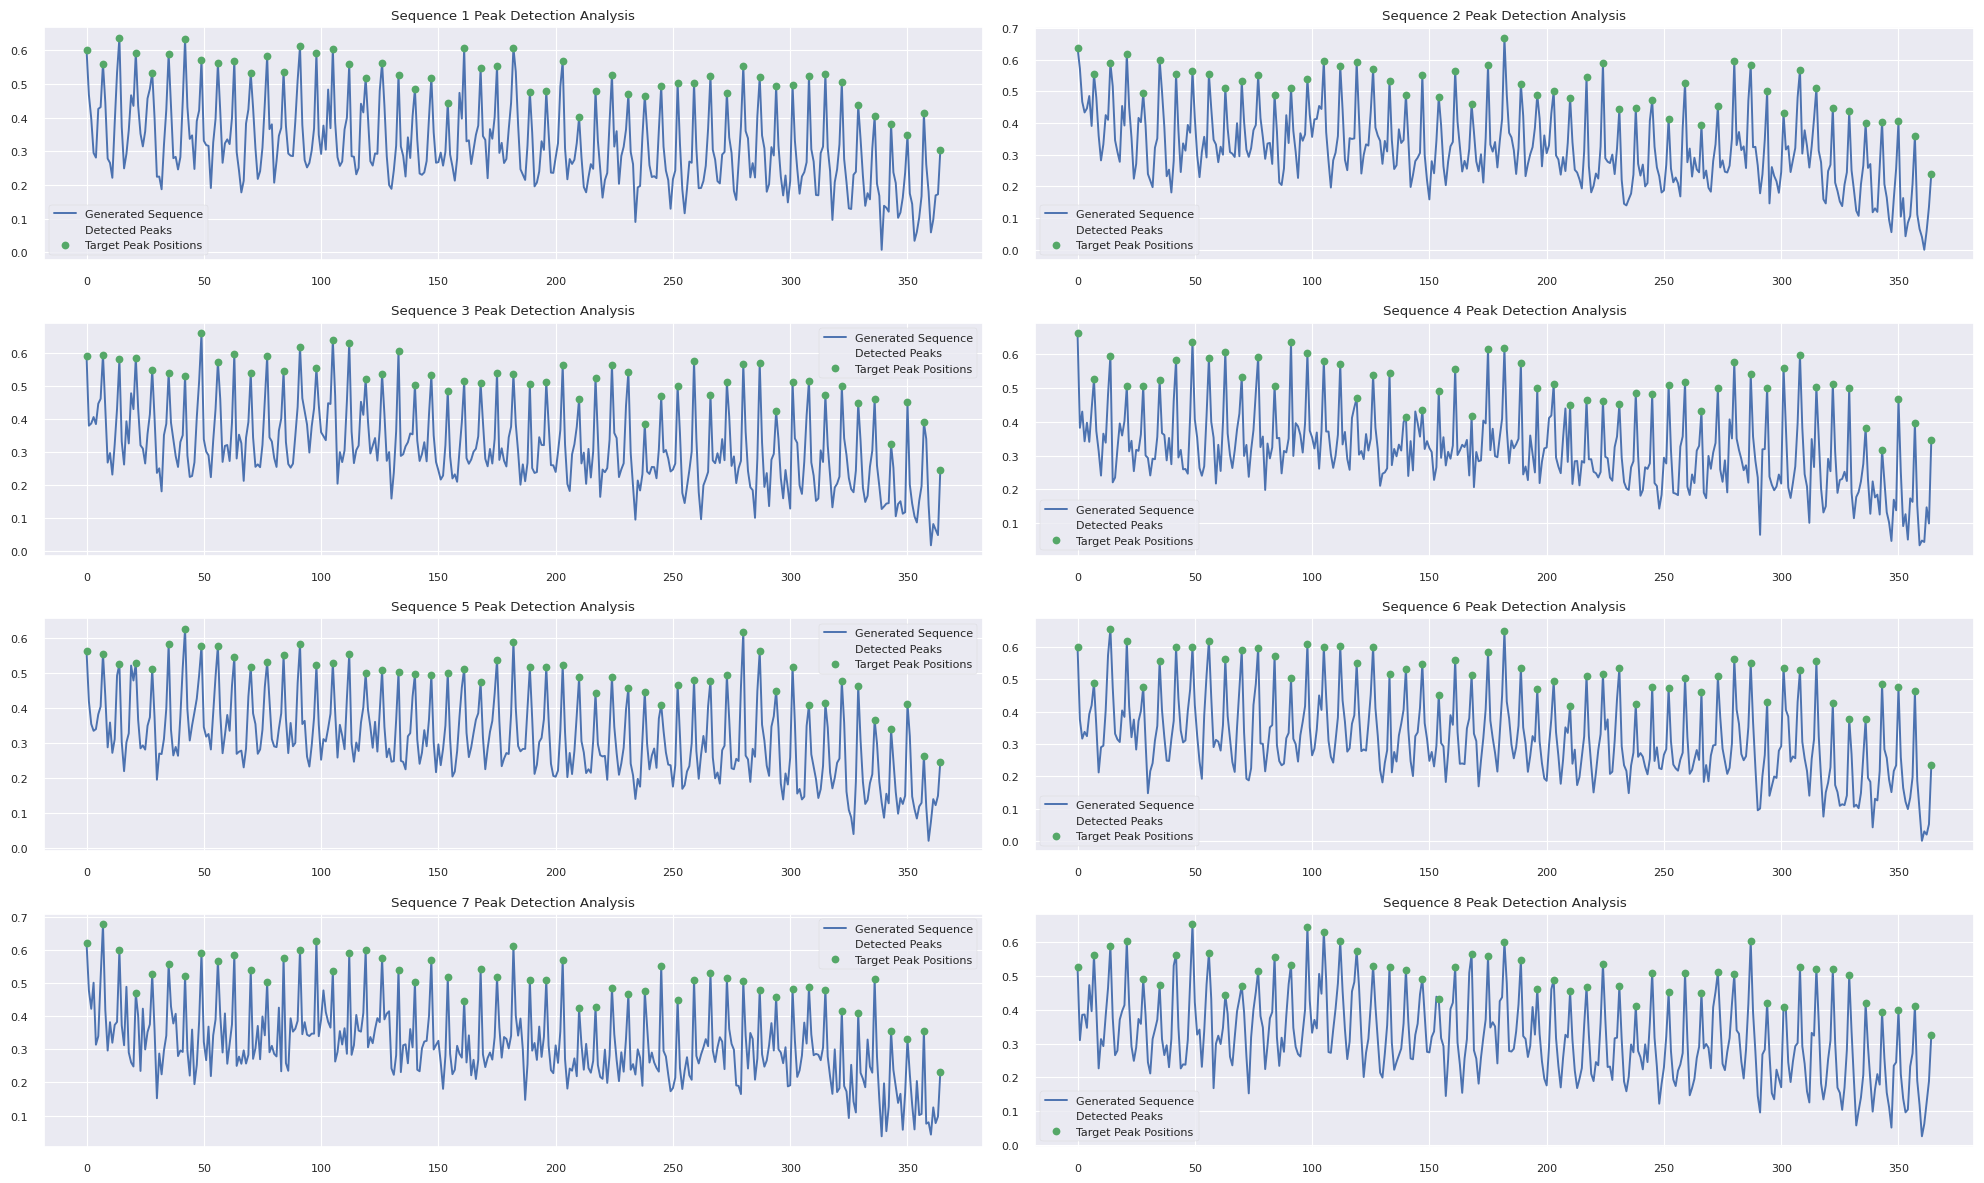


Evaluating peak_0.6_weight_0.05
Accuracy: 0.961
Precision: 37.441
Matched peaks: 15276 / 15900


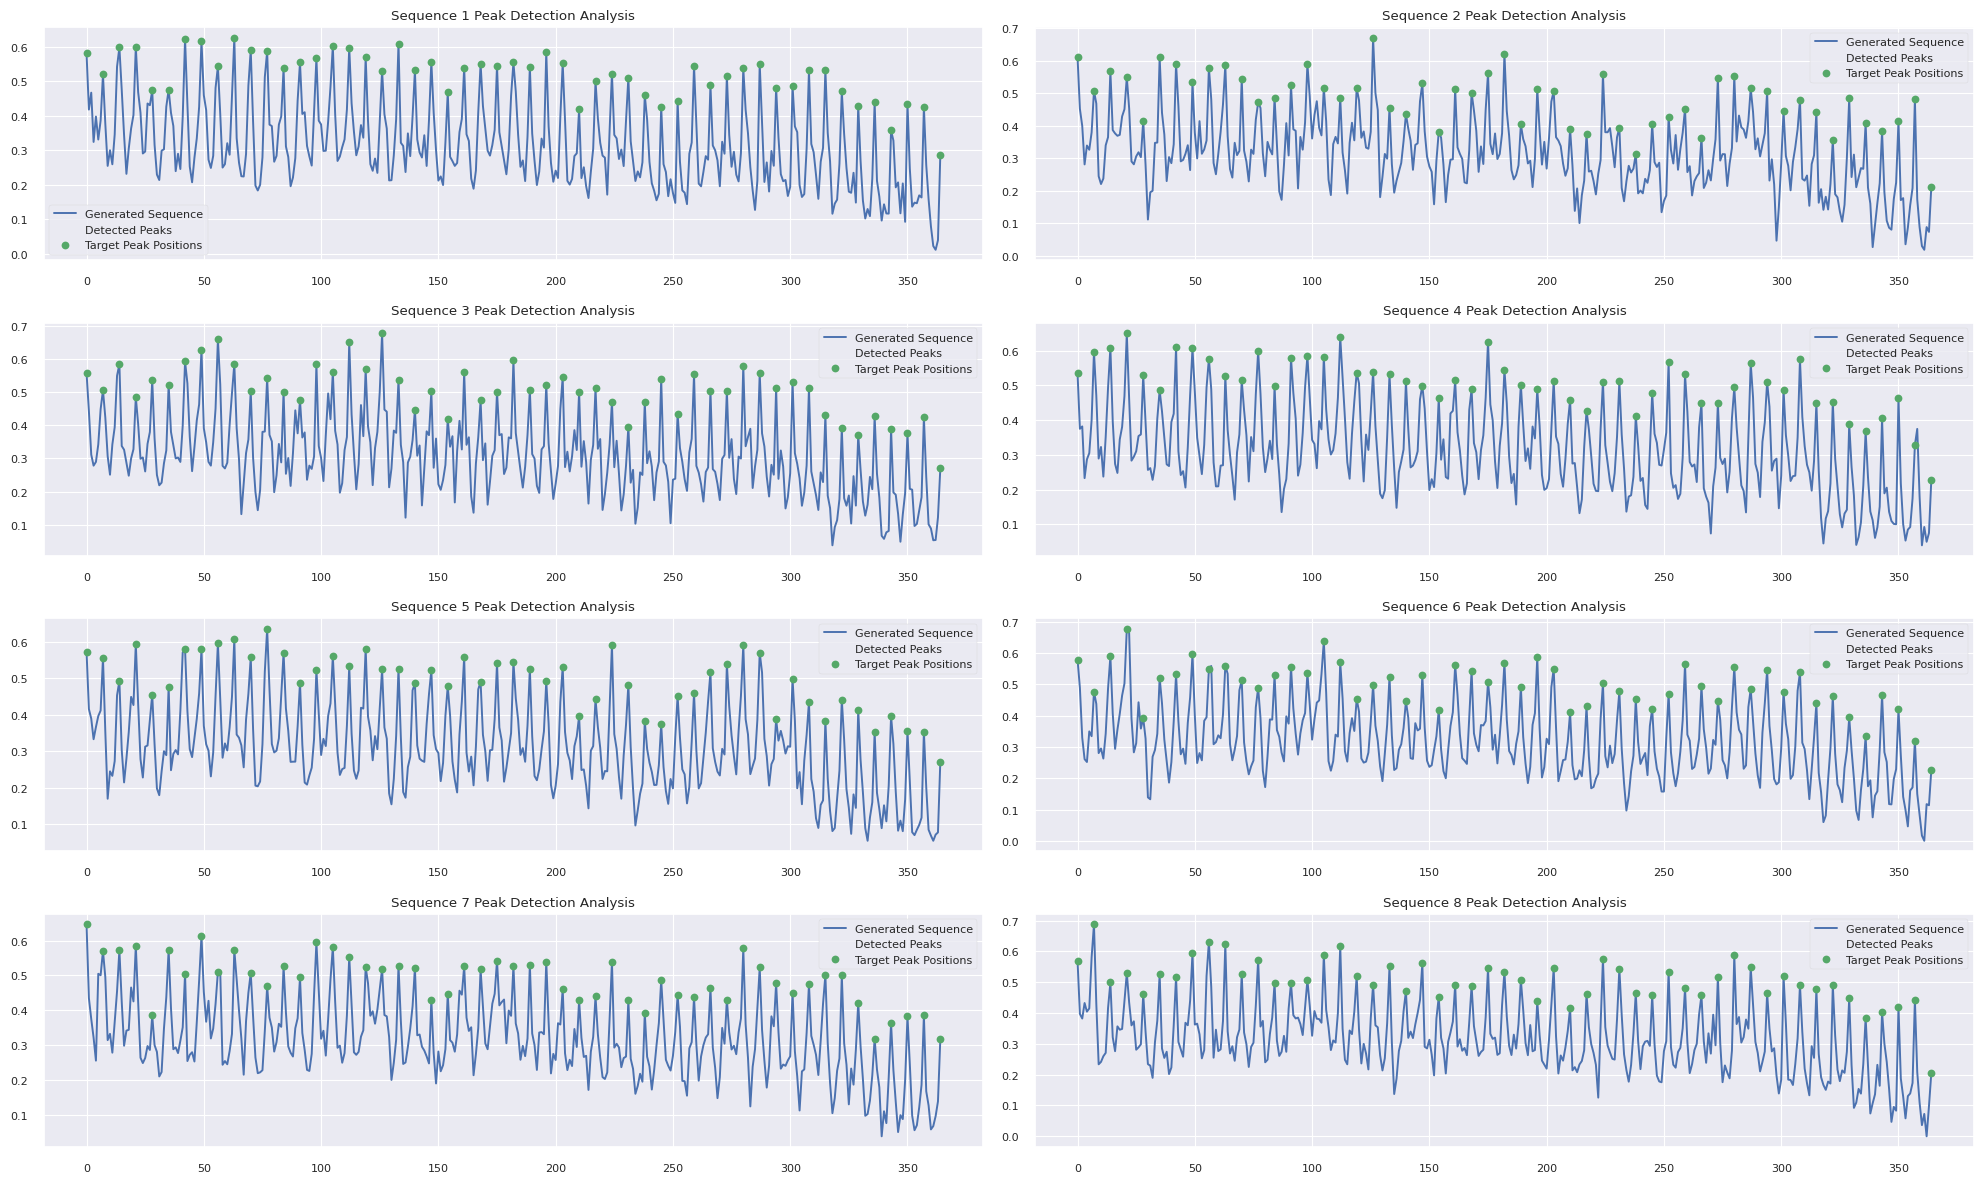


Evaluating peak_1.0_weight_0.1
Accuracy: 0.962
Precision: 37.500
Matched peaks: 15300 / 15900


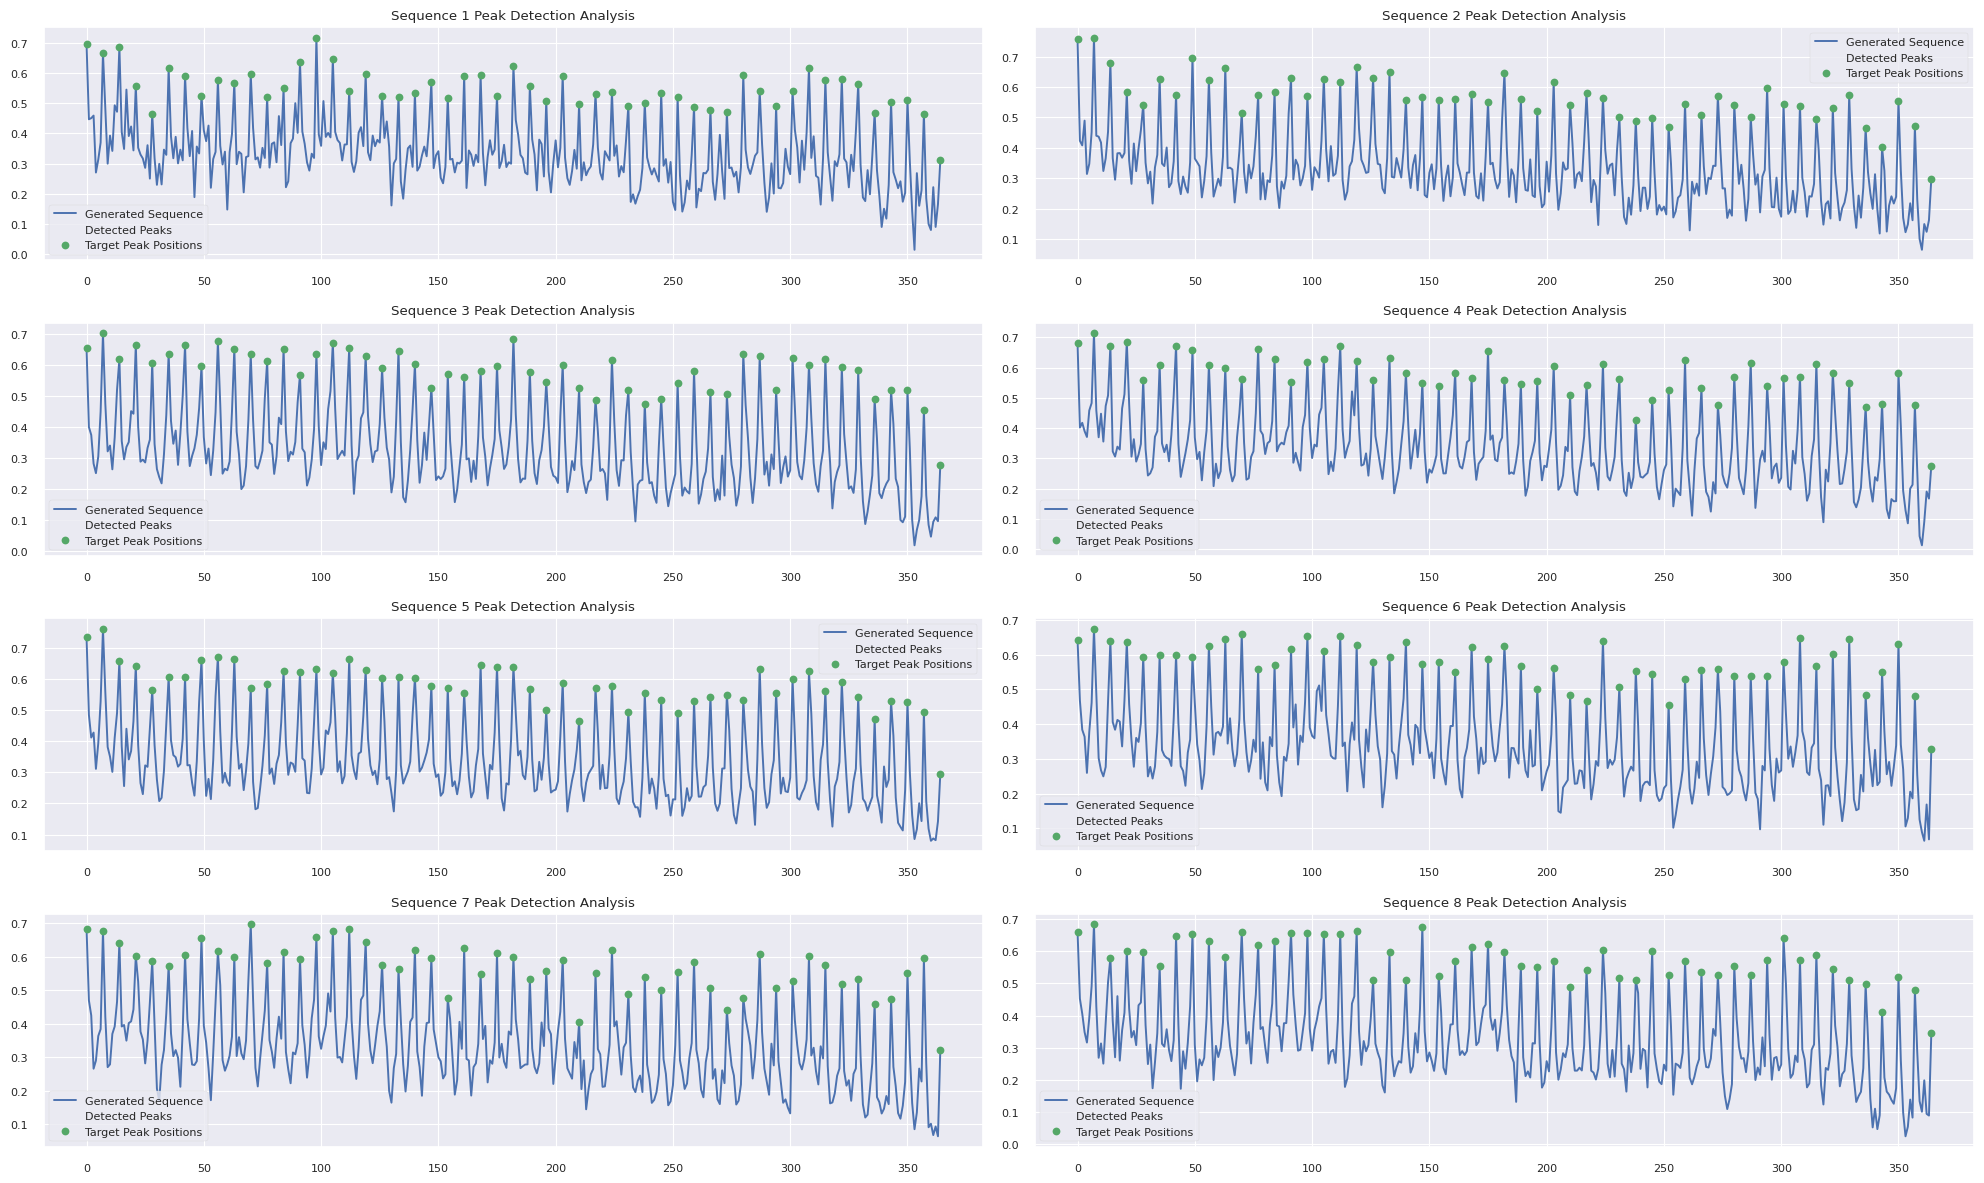


Evaluating peak_0.8_weight_0.15
Accuracy: 0.962
Precision: 37.500
Matched peaks: 15300 / 15900


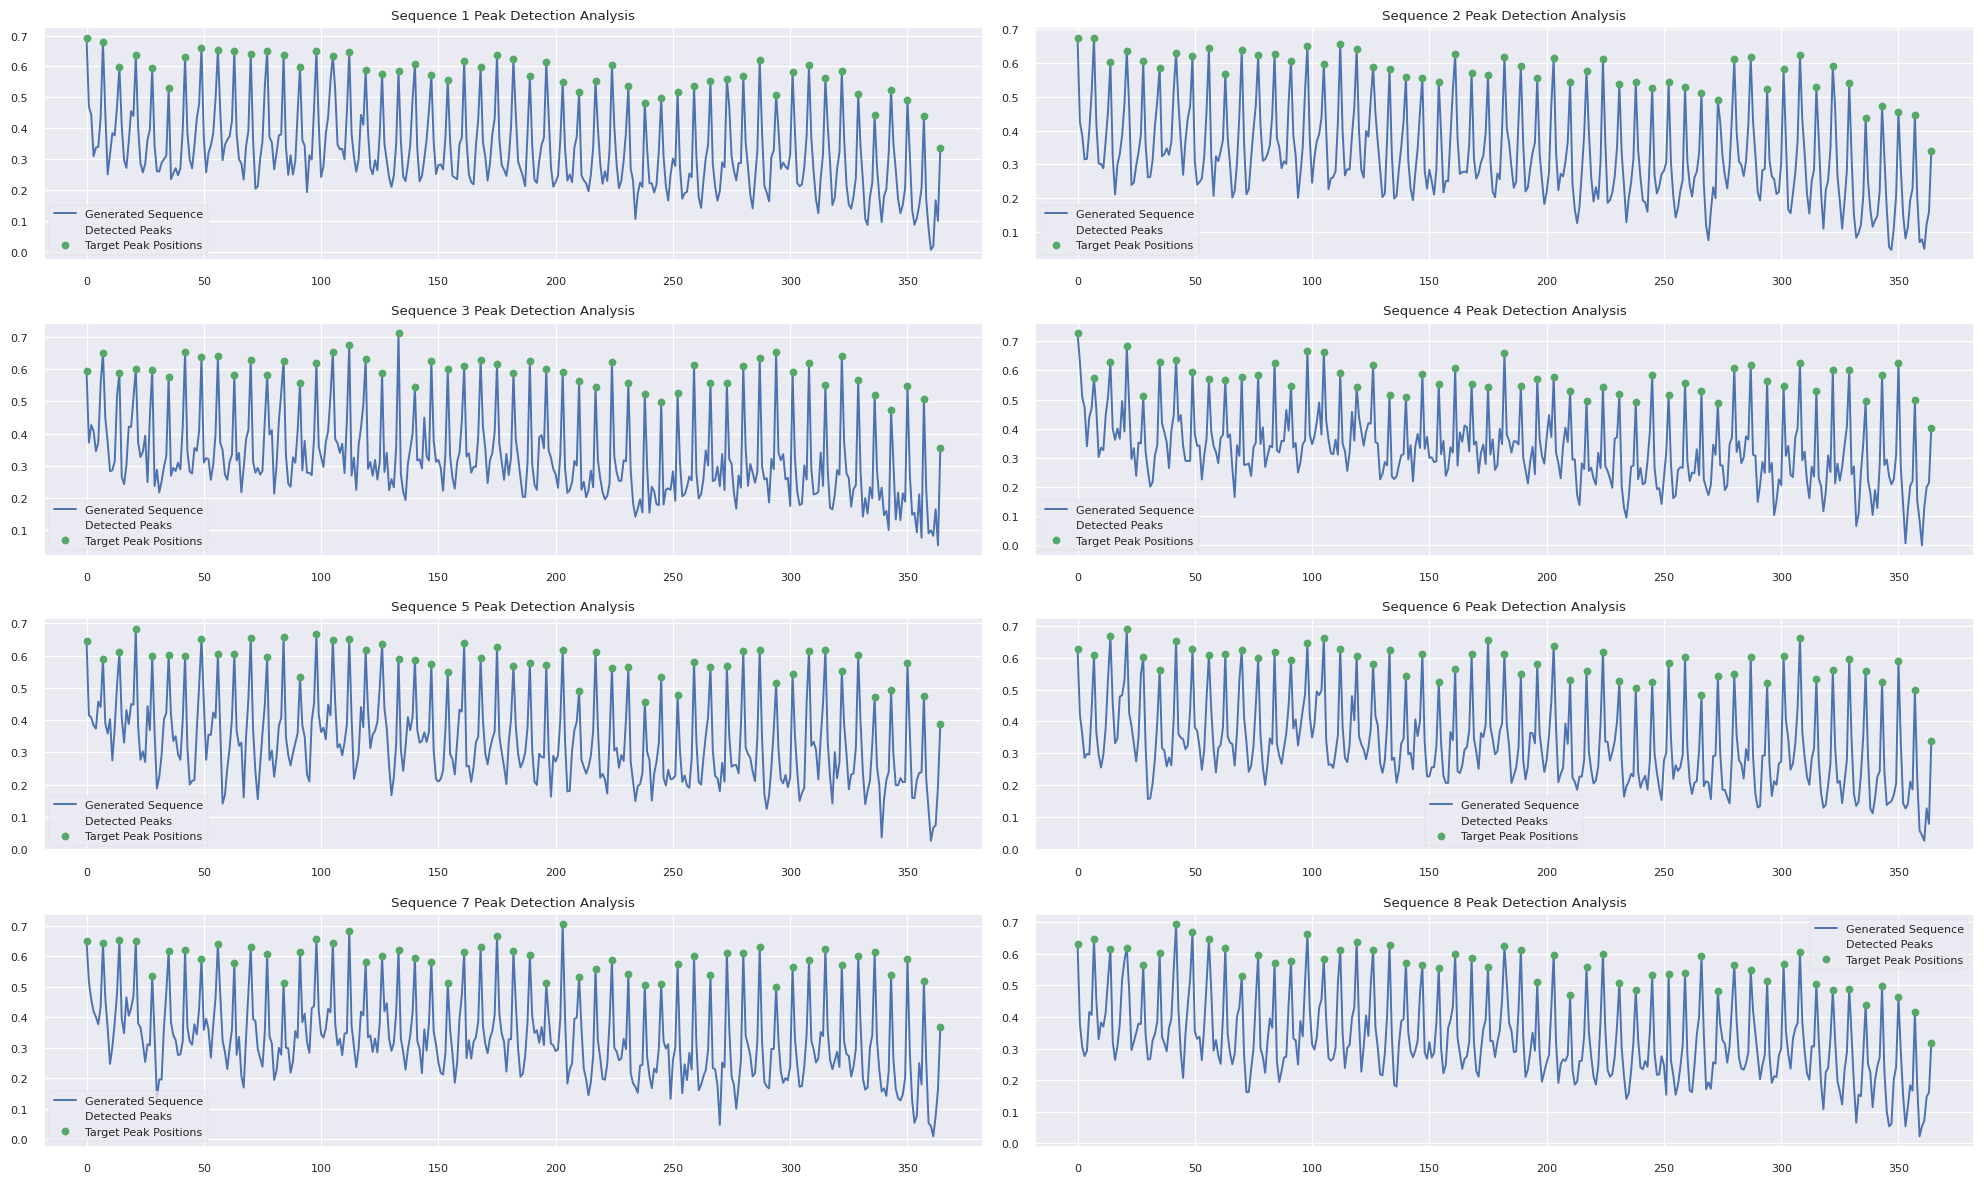


Evaluating peak_0.8_weight_0.1
Accuracy: 0.962
Precision: 37.498
Matched peaks: 15299 / 15900


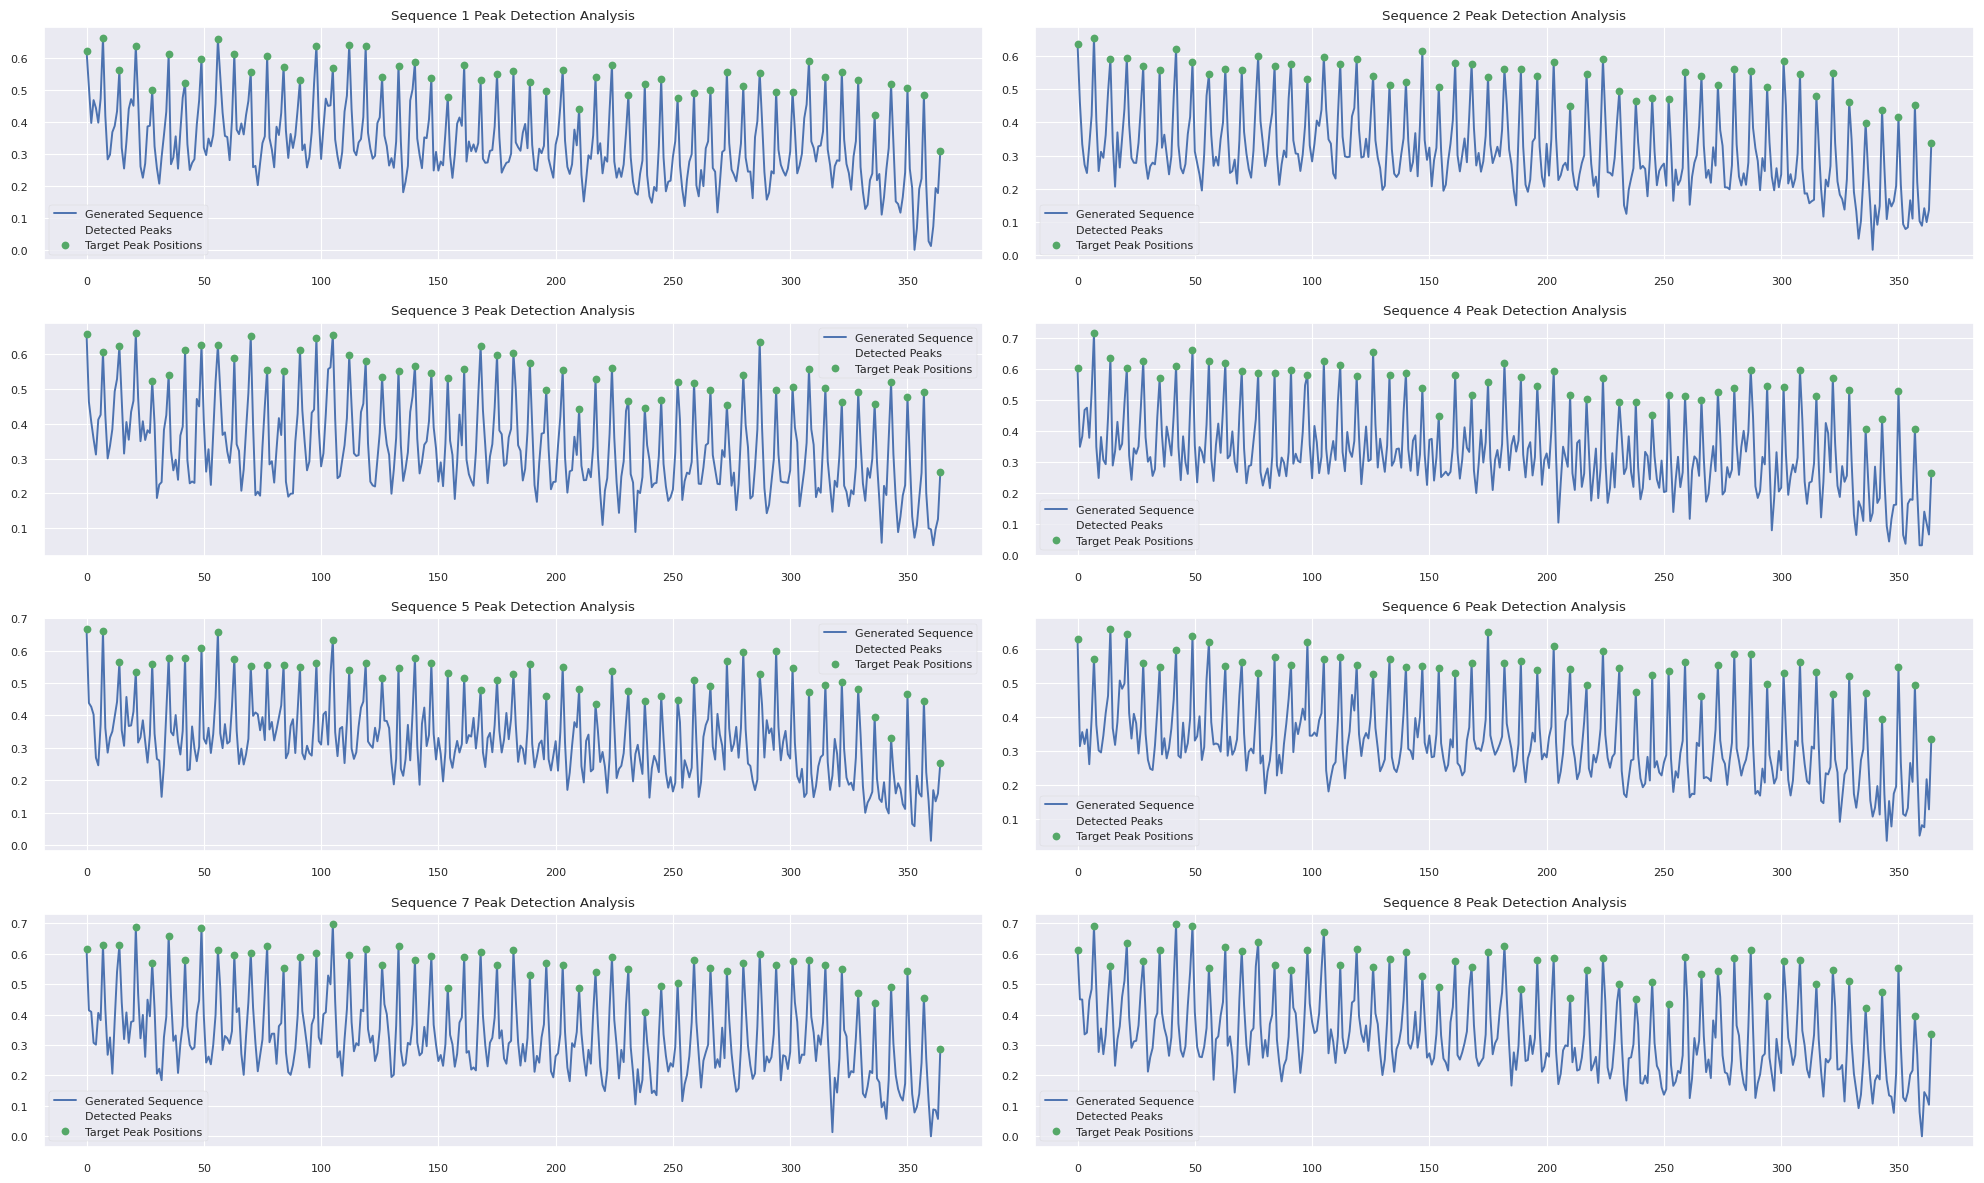


Summary of peak detection results:
                      accuracy  precision  total_targets  detected_peaks  \
peak_1.0_weight_0.15  0.962264  37.500000        15900.0           408.0   
peak_1.0_weight_0.05  0.961950  37.487745        15900.0           408.0   
peak_0.6_weight_0.1   0.961950  37.487745        15900.0           408.0   
peak_0.6_weight_0.15  0.962264  37.500000        15900.0           408.0   
peak_0.8_weight_0.05  0.961447  37.468137        15900.0           408.0   
peak_0.6_weight_0.05  0.960755  37.441176        15900.0           408.0   
peak_1.0_weight_0.1   0.962264  37.500000        15900.0           408.0   
peak_0.8_weight_0.15  0.962264  37.500000        15900.0           408.0   
peak_0.8_weight_0.1   0.962201  37.497549        15900.0           408.0   

                      matched_peaks  
peak_1.0_weight_0.15        15300.0  
peak_1.0_weight_0.05        15295.0  
peak_0.6_weight_0.1         15295.0  
peak_0.6_weight_0.15        15300.0  
peak_0.8_weig

/home/mila/h/hao.yu/tencent/Tifussion/tiffusion/external/diffusion-ts/utils/metric_utils.py:431: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(
/home/mila/h/hao.yu/tencent/Tifussion/tiffusion/external/diffusion-ts/utils/metric_utils.py:448: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.

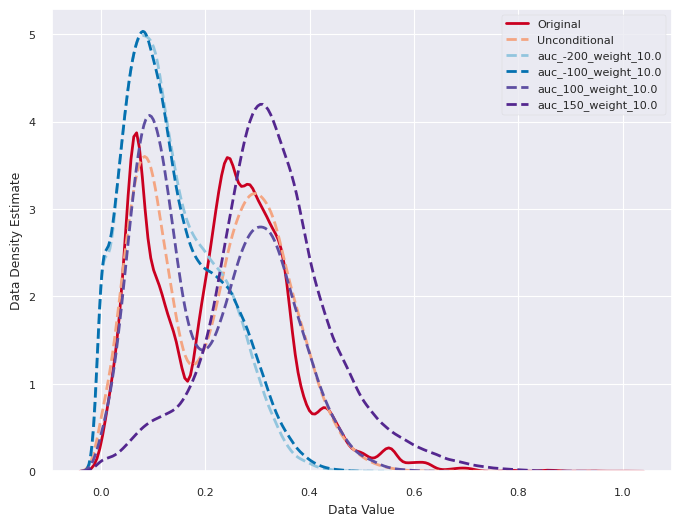

In [32]:
from utils.metric_utils import visualization_control
from IPython.display import HTML
from scipy.signal import find_peaks, peak_prominences

def evaluate_peak_detection(data, target_peaks, window_size=7, min_distance=5, prominence_threshold=0.1):
    """
    Evaluate peak detection accuracy by comparing detected peaks with target peaks.
    
    Parameters:
    data: numpy array of shape (batch_size, seq_length, features)
        The generated sequences to analyze
        The indices where peaks should occur (e.g., every 7 steps for weekly peaks)
    target_peak: list
        List of indices where peaks should occur
    window_size: int
        Size of window to consider a peak match
    """
    batch_size, seq_length, features = data.shape
    detected_peaks = []
    accuracy_metrics = {}
    
    # Create figure for visualization
    fig, axes = plt.subplots(4, 2, figsize=(20, 12))
    axes = axes.flatten()
    
    # Analyze first 8 batches and first feature (revenue)
    overall_matched = 0
    overall_targets = 0
    
    for i in range(8):
        sequence = data[i, :, 0]  # batch i, all timepoints, revenue feature
        
        # Find peaks using scipy
        peaks, properties = find_peaks(sequence, 
                                     distance=min_distance,
                                     prominence=prominence_threshold)
        
        # Plot original sequence and detected peaks
        axes[i].plot(sequence, label='Generated Sequence')
        axes[i].plot(peaks, sequence[peaks], "x", label='Detected Peaks')
        
        # Plot target peak positions
        target_positions = np.arange(0, seq_length, 7)  # Weekly peaks
        axes[i].plot(target_positions, sequence[target_positions], "o", 
                    label='Target Peak Positions')
        
        axes[i].set_title(f'Sequence {i+1} Peak Detection Analysis')
        axes[i].legend()
        axes[i].grid(True)
        
        # Count matches within window for this sequence
        matched_peaks = 0
        for target in target_positions:
            # Check if any detected peak is within the window of the target
            matches = np.any((peaks >= target - window_size//2) & 
                           (peaks <= target + window_size//2))
            if matches:
                matched_peaks += 1
                
        overall_matched += matched_peaks
        overall_targets += len(target_positions)
    
    for i in range(8, batch_size):
        peaks, properties = find_peaks(data[i, :, 0], distance=min_distance, prominence=prominence_threshold)
        matched_peaks = 0
        for target in target_peaks:
            matches = np.any((peaks >= target - window_size//2) & 
                           (peaks <= target + window_size//2))
            if matches:
                matched_peaks += 1
        overall_matched += matched_peaks
        overall_targets += len(target_peaks)
        
    # Calculate overall metrics
    accuracy = overall_matched / overall_targets
    precision = overall_matched / (len(peaks) * 8) if len(peaks) > 0 else 0
    
    accuracy_metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'total_targets': overall_targets,
        'detected_peaks': len(peaks) * 8,
        'matched_peaks': overall_matched
    }
    plt.tight_layout()
    return accuracy_metrics, peaks, prominences

# Evaluate peak detection for different control settings
peak_accuracies = {}
for key, data in anchor_controled_data.items():
    print(f"\nEvaluating {key}")
    metrics, peaks, prominences = evaluate_peak_detection(data, 
                                                        target_peaks=range(0, 365, 7),
                                                        window_size=2)
    peak_accuracies[key] = metrics
    print(f"Accuracy: {metrics['accuracy']:.3f}")
    print(f"Precision: {metrics['precision']:.3f}")
    print(f"Matched peaks: {metrics['matched_peaks']} / {metrics['total_targets']}")
    plt.show()

# Display summary of results
df_metrics = pd.DataFrame(peak_accuracies).T
print("\nSummary of peak detection results:")
print(df_metrics)

# Sum control
data = {
    "ori_data": ori_data[:, :, :1],
    "Unconditional": unconditional_data[:, :, :1],
}
# for key, value in sum_controled_data.items():
#     if "weight_10" in key:
#         data[key] = value
#         print(key)
keys = [
    "auc_-200_weight_10.0",
    "auc_-100_weight_10.0",
    "auc_100_weight_10.0",
    "auc_150_weight_10.0",
]
for key in keys:
    data[key] = sum_controled_data[key][:, :, :1]
    # print sum value
    print(f"Sum of {key}: {np.sum(sum_controled_data[key][:, :, 0])}")
# visualization_control(
#     data=data,
#     analysis="pca",
#     compare=ori_data.shape[0],
#     output_label="revenue"
# )
# visualization_control(
#     data=data,
#     analysis="tsne",
#     compare=ori_data.shape[0],
#     output_label="revenue"
# )
visualization_control(
    data=data,
    analysis="kernel",
    compare=ori_data.shape[0],
    output_label="revenue"
)

# Create animation
import matplotlib.animation as animation
import seaborn as sns

# Sort AUC values for better visualization
sorted_auc_values = sorted([int(k.split('_')[1]) for k in keys])
sorted_keys = [f"auc_{auc}_weight_10.0" for auc in sorted_auc_values]

# Create the animation
fig_anim, ax_anim = plt.subplots(figsize=(12, 8))
plt.style.use('seaborn-v0_8-paper')

def animate(frame):
    ax_anim.clear()
    key = sorted_keys[frame]
    auc_value = int(key.split('_')[1])
    data_frame = data[key]
    
    # Plot histograms
    ax_anim.hist(data_frame[:, :, 0].flatten(), bins=50, alpha=0.6, label='Generated', color='skyblue')
    ax_anim.hist(ori_data[:, :, 0].flatten(), bins=50, alpha=0.6, label='Original', color='lightcoral')
    
    # Customize the plot
    ax_anim.set_title(f'Revenue Distribution\nAUC Target: {auc_value}', fontsize=14, pad=20)
    ax_anim.set_xlabel('Value', fontsize=12)
    ax_anim.set_ylabel('Frequency', fontsize=12)
    ax_anim.legend(fontsize=12)
    ax_anim.grid(True, alpha=0.3)

# Create animation with slower frame rate (2 seconds per frame)
anim = animation.FuncAnimation(fig_anim, animate, frames=len(sorted_keys), interval=2000)

# Save as GIF
anim.save('revenue_distribution.gif', writer='pillow')

# Display animation in notebook
plt.close(fig_anim)  # Prevent duplicate display
HTML(anim.to_jshtml())

In [ ]:
# import matplotlib.pyplot as plt
# plt.style.available

# for auc weight
sns.set_theme(style="darkgrid")
data = {
    "ori_data": ori_data,
    "Unconditional": unconditional_data,
}
for key, value in sum_controled_data.items():
    if "auc_100" in key:
        data[key] = value
        print(key)
        
sorted_auc_values = sorted([float(k.split('_')[3]) for k in sum_controled_data.keys()])
sorted_keys = [f"auc_100_weight_{weight}" for weight in sorted_auc_values]

fig, ax = plt.subplots(figsize=(12, 8))
plt.style.use('seaborn-v0_8-paper')

def animate(frame):
    ax.clear()
    key = sorted_keys[frame]
    auc_value = float(key.split('_')[3])
    data_frame = data[key]
    
    # Plot histograms
    ax.hist(data_frame[:, :, 0].flatten(), bins=50, alpha=0.6, label='Generated', color='skyblue')
    ax.hist(ori_data[:, :, 0].flatten(), bins=50, alpha=0.6, label='Original', color='lightcoral')
    
    # Customize the plot
    ax.set_title(f'Revenue Distribution\nAUC Target Wight: {auc_value}', fontsize=14, pad=20)
    ax.set_xlabel('Value', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.legend(fontsize=12)
    ax.grid(True, alpha=0.3)
    
# Create animation with slower frame rate (2 seconds per frame)
anim = animation.FuncAnimation(fig, animate, frames=len(sorted_keys), interval=2000)

# Save as GIF
# anim.save('revenue_distribution_auc.gif', writer='pillow')

# Display animation in notebook
plt.close(fig)  # Prevent duplicate display
HTML(anim.to_jshtml())


auc_100_weight_5.0
auc_100_weight_1.0
auc_100_weight_10.0
auc_100_weight_15.0


### Visualization

We visualize the original and synthetic data distributions using PCA, tSNE and Density analysis.

In [11]:
from utils.metric_utils import visualization_control
# plot_data = {
#     "ori_data": ori_data,
#     "Unconditional": unconditional_data,
#     "Sum Controled": sum_controled_data,
#     "Anchor Controled": anchor_controled_data,
# }

In [12]:
# plot_data = {
#     "ori_data": ori_data,
#     "Unconditional": unconditional_data,
#     "Sum Controled": sum_controled_data,
#     "Anchor Controled": anchor_controled_data,
# }
# visualization_control(
#     data=plot_data,
#     analysis="pca",
#     compare=ori_data.shape[0],
#     output_label="revenue"
# )

In [13]:
# plot_data = {
#     "ori_data": ori_data,
#     "Unconditional": unconditional_data,
#     "Sum Controled": sum_controled_data,
#     "Anchor Controled": anchor_controled_data,
# }

# visualization_control(
#     data=plot_data,
#     analysis="tsne",
#     compare=ori_data.shape[0],
#     output_label="revenue"
# )

In [14]:
# plot_data = {
#     "ori_data": ori_data,
#     "Unconditional": unconditional_data,
#     "Sum Controled": sum_controled_data,
#     "Anchor Controled": anchor_controled_data,
# }
# visualization_control(
#     data=plot_data,
#     analysis="kernel",
#     compare=ori_data.shape[0],
#     output_label="revenue"
# )